# Diabetes Linear Regression Neural Network

In [1]:
from sklearn.datasets import load_diabetes
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from torch import nn
from torch import tensor
import torch

import matplotlib.pyplot as plt

In [2]:
device = "cpu"

## Loading the Data

In [3]:
class DiabetesDataset(Dataset):
    """PyTorch Dataset wrapped around the sklearn diabetes dataset"""

    def __init__(self):
        self.diabetes_dataset = load_diabetes()
        self.features = self.diabetes_dataset["data"]  # X
        self.labels = self.diabetes_dataset["target"]  # y
        self.feature_names = self.diabetes_dataset["feature_names"]

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx: int):
        return torch.tensor(self.features[idx], dtype=torch.float), torch.tensor(self.labels[idx], dtype=torch.float)

In [4]:
# Create an instance of the dataset
diabetes_dataset = DiabetesDataset()

In [5]:
desired_split = [0.7, 0.3]
train_dataset, val_dataset = random_split(diabetes_dataset, desired_split)

In [6]:
print(f"Aiming for a split of {desired_split}.")
print(f"Length of total dataset: {len(diabetes_dataset)}")
print(f"Length of train dataset: {len(train_dataset)} ({100 * len(train_dataset)/len(diabetes_dataset):.2f}%)")
print(f"Length of test dataset: {len(val_dataset)} ({100 * len(val_dataset)/len(diabetes_dataset):.2f}%)")

Aiming for a split of [0.7, 0.3].
Length of total dataset: 442
Length of train dataset: 310 (70.14%)
Length of test dataset: 132 (29.86%)


## Defining the Model

### Super simple linear regression

In [7]:
class LinearDiabetesRegressor(nn.Module):
    def __init__(self, num_features: int):
        super().__init__()

        # Initalise some weights for a linear model drawn from normal distribution
        self.weight = torch.normal(0, 0.01, (num_features,), requires_grad=True)

        # Initialise bias to 0.
        self.bias = torch.zeros(1, requires_grad=True)

    def forward(self, X: torch.Tensor):
        """Simple forward pass, not even using the torch constructors for NNs"""
        return torch.matmul(self.weight, X) + self.bias

    def loss(self, y_hat: torch.Tensor, y: torch.Tensor):
        """Mean squared error losss"""
        return torch.mean((y - y_hat)**2/2)

    def configure_optimizer(self, lr: float):
        # Because we haven't specified a neural network normally, we configure the optimiser this way.
        self.optimizer = torch.optim.SGD([
            {'params': self.weight},
            {'params': self.bias}], lr=learning_rate)

In [8]:
model = LinearDiabetesRegressor(len(diabetes_dataset.feature_names)).to(device)

In [9]:
# Before training the model, we can use the forward method, nothing to change here except the weights and the biases!
random_prediction = model(val_dataset[0][0])
print(random_prediction)

tensor([-0.0005], grad_fn=<AddBackward0>)


## Training the model

### Training Loop (three steps)
1. Zero all gradients so that they don't add up
2. Backpropagate the gradients with loss.backward()
3. Call optimizer.step() to update the parameters in the direction of the computed gradients.

In [10]:
def train_loop(dataloader, model):
    size = len(dataloader.dataset)
    
    # best practise
    model.train()

    for batch, (X, y) in enumerate(dataloader):

        # make a prediction
        pred = model(X)
        loss = model.loss(pred, y)

        # Backpropagation
        loss.backward()
        model.optimizer.step()
        model.optimizer.zero_grad()

    return float(loss)

In [11]:
def test_loop(dataloader, model):
    # best practise
    model.eval()

    num_batches = len(dataloader)
    test_loss = 0
    
    # Don't want to waste time computing gradients on validation check
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            loss = model.loss(pred, y)
            test_loss += loss

    
    test_loss /= num_batches
    return float(test_loss)

In [15]:
# Full/fresh loading and training loop.

# Hyperparameters
learning_rate = 1e-3
batch_size = 64
epochs = 10

# Prep Data
diabetes_dataset = DiabetesDataset()
desired_split = [0.7, 0.3]
train_dataset, val_dataset = random_split(diabetes_dataset, desired_split)

# Prep model
model = LinearDiabetesRegressor(num_features = len(diabetes_dataset.feature_names))
model.configure_optimizer(lr=learning_rate)

# Train the model
losses = {
    "train_loss": [],
    "test_loss": []
}
for epoch in range(epochs):
    print(f"Epoch: {epoch+1} \n {10*'#'}")
    losses["train_loss"].append(train_loop(train_dataset, model))
    losses["test_loss"].append(test_loop(val_dataset, model))

    print(f"Train loss: {losses['train_loss'][-1]}, Test Loss: {losses['test_loss'][-1]}")

Epoch: 1 
 ##########
Train loss: 143.66619873046875, Test Loss: 9517.4677734375
Epoch: 2 
 ##########
Train loss: 77.03998565673828, Test Loss: 6523.796875
Epoch: 3 
 ##########
Train loss: 574.490478515625, Test Loss: 4881.025390625
Epoch: 4 
 ##########
Train loss: 1230.173828125, Test Loss: 3972.8740234375
Epoch: 5 
 ##########
Train loss: 1864.747314453125, Test Loss: 3465.76611328125
Epoch: 6 
 ##########
Train loss: 2410.261962890625, Test Loss: 3178.70068359375
Epoch: 7 
 ##########
Train loss: 2851.01904296875, Test Loss: 3013.18017578125
Epoch: 8 
 ##########
Train loss: 3193.837158203125, Test Loss: 2915.376220703125
Epoch: 9 
 ##########
Train loss: 3453.5322265625, Test Loss: 2855.720947265625
Epoch: 10 
 ##########
Train loss: 3646.270751953125, Test Loss: 2817.84423828125


## Plot a figure to make sure it's actually training...

(It's pretty awful, but then we are trying to do linear regression on a 10 dimensional dataset). Clearly this model is too simple to capture the complexity of the given dataset, even if we do something ridiculous like allowing 50 epochs for training, we still don't manage to overfit our model. 

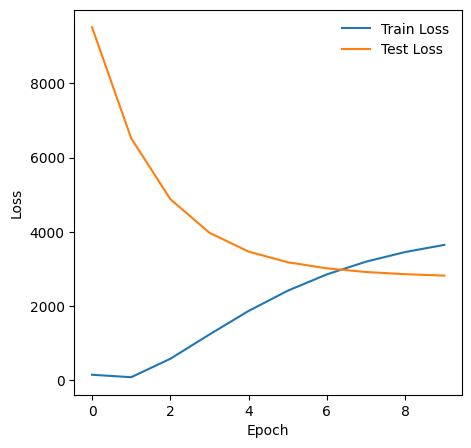

In [16]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 5))

ax.plot(range(epochs), losses["train_loss"], label="Train Loss")
ax.plot(range(epochs), losses["test_loss"], label="Test Loss")

ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.legend(frameon=False)

plt.show()